In [ ]:
!pip install datasets fasttext

Ссылка на эту тетрадку в колабе: https://colab.research.google.com/drive/1lKM5pi_6-VIp7CENURLst5Gd4yNUcxUn?usp=sharing

In [3]:
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import classification_report
from collections import Counter
import numpy as np


In [4]:
dataset = load_dataset("xtreme", "udpos.English")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [64]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 21253
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3974
    })
    test: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 5440
    })
})

In [5]:
tags = dataset['train'].features['pos_tags'].feature
tags

ClassLabel(names=['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X'], id=None)

In [6]:
label2id = {'ADJ':0, 'ADP': 1, 'ADV': 2, 'AUX': 3, 'CCONJ': 4, 'DET': 5, 'INTJ': 6, 'NOUN': 7, 'NUM': 8, 'PART': 9, 'PRON': 10, 'PROPN': 11, 'PUNCT': 12, 'SCONJ': 13, 'SYM': 14, 'VERB': 15, 'X': 16}
id2label = {0: 'ADJ', 1: 'ADP', 2: 'ADV', 3: 'AUX', 4: 'CCONJ', 5: 'DET', 6: 'INTJ', 7: 'NOUN', 8: 'NUM', 9: 'PART', 10: 'PRON', 11: 'PROPN', 12: 'PUNCT', 13: 'SCONJ', 14: 'SYM', 15: 'VERB', 16: 'X'}


In [67]:
label2id

{'ADJ': 0,
 'ADP': 1,
 'ADV': 2,
 'AUX': 3,
 'CCONJ': 4,
 'DET': 5,
 'INTJ': 6,
 'NOUN': 7,
 'NUM': 8,
 'PART': 9,
 'PRON': 10,
 'PROPN': 11,
 'PUNCT': 12,
 'SCONJ': 13,
 'SYM': 14,
 'VERB': 15,
 'X': 16}

-----------------

In [7]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x for x in sent])

Будем использовать предобученные эмбеддинги

In [8]:
from huggingface_hub import hf_hub_download
import fasttext

model_fasttext = fasttext.load_model(hf_hub_download("facebook/fasttext-en-vectors", "model.bin"))

In [9]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [12]:
X_valid = []

for sent in dataset['validation']['tokens']:
    tokens = [w for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_valid.append(ids)

In [13]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [14]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [15]:
import keras
print(keras.__version__)

2.15.0


In [16]:
MAX_LEN = max(len(x) for x in X)

X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [17]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['pos_tags'], value=16,
                                                  maxlen=MAX_LEN,  padding='post')
y_valid = keras.preprocessing.sequence.pad_sequences(dataset['validation']['pos_tags'], value=16,
                                                       maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['pos_tags'], value=16,
                                                       maxlen=MAX_LEN,  padding='post')

In [18]:
embedding_dim = model_fasttext.get_dimension()
embedding_matrix = np.zeros((len(word2id), embedding_dim))

In [19]:
embedding_dim

300

In [20]:
for word, idx in word2id.items():
    if word in model_fasttext:
        embedding_matrix[idx] = model_fasttext.get_word_vector(word)
    else:
        embedding_matrix[idx] = np.zeros(embedding_dim)
        pass

In [21]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=300, trainable=False,
                                       weights=[embedding_matrix])(inputs)

bilstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bilstm1)
bilstm3 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bilstm2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(bilstm3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 209)]             0         
                                                                 
 embedding (Embedding)       (None, 209, 300)          8880900   
                                                                 
 bidirectional (Bidirection  (None, 209, 256)          439296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 209, 256)          394240    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 209, 256)          394240    
 onal)                                                           
                                                             

In [23]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
167/167 [==============================] - 33s 131ms/step - loss: 0.2360 - accuracy: 0.9272 - val_loss: 0.1499 - val_accuracy: 0.9497
Epoch 2/5
167/167 [==============================] - 20s 118ms/step - loss: 0.1095 - accuracy: 0.9656 - val_loss: 0.0643 - val_accuracy: 0.9803
Epoch 3/5
167/167 [==============================] - 20s 122ms/step - loss: 0.0494 - accuracy: 0.9849 - val_loss: 0.0473 - val_accuracy: 0.9868
Epoch 4/5
167/167 [==============================] - 20s 123ms/step - loss: 0.0325 - accuracy: 0.9901 - val_loss: 0.0456 - val_accuracy: 0.9887
Epoch 5/5
167/167 [==============================] - 20s 122ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.0395 - val_accuracy: 0.9904


In [24]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


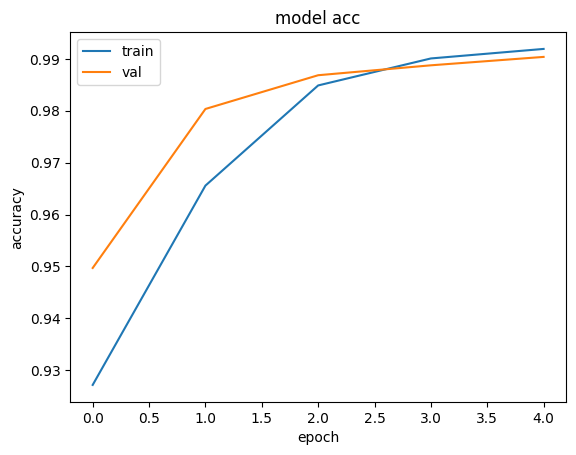

In [25]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
from sklearn.metrics import classification_report

In [27]:
pred = model.predict(X_test).argmax(2)

170/170 [==============================] - 5s 20ms/step


In [28]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2label.keys()),
                                                                     target_names=list(id2label.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

         ADJ       0.89      0.70      0.78      5732
         ADP       0.93      0.95      0.94      8446
         ADV       0.80      0.70      0.74      3788
         AUX       0.91      0.96      0.93      4531
       CCONJ       0.98      0.98      0.98      2515
         DET       0.98      0.97      0.97      7538
        INTJ       0.76      0.21      0.33       164
        NOUN       0.90      0.80      0.85     15486
         NUM       0.93      0.72      0.81      1526
        PART       0.90      0.91      0.90      1961
        PRON       0.94      0.95      0.94      6383
       PROPN       0.63      0.84      0.72      5818
       PUNCT       0.83      1.00      0.91     10389
       SCONJ       0.75      0.65      0.69      1306
         SYM       0.92      0.47      0.63       173
        VERB       0.87      0.85      0.86      9031
           X       1.00      1.00      1.00   1052173

    accuracy              

In [29]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [42]:
label_seq(sentence, word2id, id2label, MAX_LEN, model)

1/1 [==============================] - 0s 37ms/step


[('When', 'SCONJ'),
 ('we', 'PRON'),
 ('flew', 'VERB'),
 ('to', 'ADP'),
 ('the', 'DET'),
 ('coast', 'NOUN'),
 (',', 'PUNCT'),
 ('I', 'PRON'),
 ('wanted', 'VERB'),
 ('to', 'PART'),
 ('water', 'VERB'),
 ('a', 'DET'),
 ('book', 'NOUN'),
 ('.', 'PUNCT')]

In [41]:
sentence = "When we flew to the coast, I wanted to water a book."

In [44]:
label_seq(sentence2, word2id, id2label, MAX_LEN, model)

1/1 [==============================] - 0s 36ms/step


[('I', 'PRON'),
 ('was', 'AUX'),
 ('trying', 'VERB'),
 ('to', 'PART'),
 ('book', 'VERB'),
 ('a', 'DET'),
 ('hotel', 'NOUN'),
 ('for', 'ADP'),
 ('the', 'DET'),
 ('night', 'NOUN'),
 ('when', 'SCONJ'),
 ('the', 'DET'),
 ('coast', 'NOUN'),
 ('guard', 'NOUN'),
 ('appered', 'PUNCT'),
 ('out', 'ADP'),
 ('of', 'ADP'),
 ('water', 'NOUN'),
 ('.', 'PUNCT')]

In [43]:
sentence2 = "I was trying to book a hotel for the night when the coast guard appered out of water."

Видим, что в предложениях правильно снята омонимия со слов *book* и *water*, остальные части речи также соответствуют действительности. 